## Parte 2. Selección e Ingeniería de caracteristicas

In [3]:
# importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_processed = pd.read_csv('../data/processed/bike_sharing_processed.csv')
df_no_outliers= pd.read_csv('../data/clean/bike_sharing_no_outliers.csv')
#df_fe = df_processed.copy()
df_fe=df_no_outliers.copy()

In [5]:
df_fe.shape

(10551, 18)

In [6]:
# Revisando tipado de datos
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10551 entries, 0 to 10550
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      10439 non-null  object 
 1   season      10551 non-null  int64  
 2   yr          10551 non-null  int64  
 3   mnth        10551 non-null  int64  
 4   hr          10551 non-null  int64  
 5   holiday     10551 non-null  int64  
 6   weekday     10551 non-null  int64  
 7   workingday  10551 non-null  int64  
 8   weathersit  10551 non-null  int64  
 9   temp        10551 non-null  float64
 10  atemp       10551 non-null  float64
 11  hum         10551 non-null  float64
 12  windspeed   10551 non-null  float64
 13  casual      10551 non-null  int64  
 14  registered  10551 non-null  int64  
 15  cnt         10551 non-null  int64  
 16  instant     10551 non-null  int64  
 17  dteday_dt   10439 non-null  object 
dtypes: float64(4), int64(12), object(2)
memory usage: 1.4+ MB


In [7]:
# fechas
if not np.issubdtype(df_fe['dteday'].dtype, np.datetime64):
    df_fe['dteday'] = pd.to_datetime(df_fe['dteday'], errors='coerce')
    df_no_outliers['dteday'] = pd.to_datetime(df_no_outliers['dteday'], errors='coerce')

# datos con tipo de dato entero
for c in ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','instant']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce').round().astype('Int64')

# datos con tipo de dato continuo
for c in ['temp','atemp','hum','windspeed','cnt']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce')

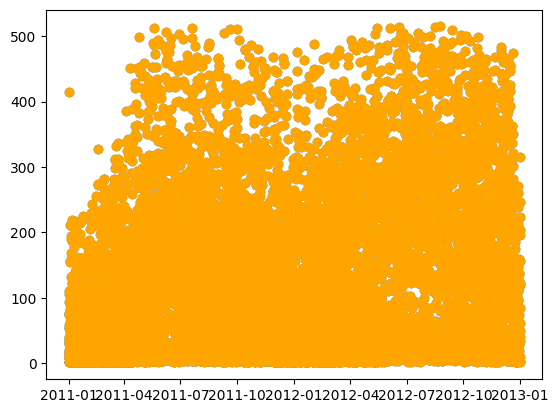

In [8]:
plt.scatter(df_fe['dteday'],df_fe['cnt'])
plt.scatter(df_no_outliers['dteday'],df_no_outliers['cnt'], color='orange')

### Generamos más variables a partir de las existentes para ayudar a la interpretabilidad

In [9]:
# Temporales derivadas
df_fe['dayofyear'] = df_fe['dteday'].dt.dayofyear
df_fe['is_weekend'] = df_fe['weekday'].isin([0,6]).astype(int)

# Codificación cíclica: ayuda a que el modelo entienda que son ciclos
# hora (0-23)
df_fe['hr_sin']  = np.sin(2*np.pi * df_fe['hr'].astype(float) / 24.0)
df_fe['hr_cos']  = np.cos(2*np.pi * df_fe['hr'].astype(float) / 24.0)

# mes (1-12)
df_fe['mnth_sin'] = np.sin(2*np.pi * df_fe['mnth'].astype(float) / 12.0)
df_fe['mnth_cos'] = np.cos(2*np.pi * df_fe['mnth'].astype(float) / 12.0)

# día del año (1-366)
df_fe['doy_sin'] = np.sin(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)
df_fe['doy_cos'] = np.cos(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)

# Interacciones climáticas simples (no lineales y combinaciones útiles)
df_fe['temp_diff']  = df_fe['atemp'] - df_fe['temp']       # sensación - temperatura
df_fe['temp_x_hum'] = df_fe['temp'] * df_fe['hum']         # bochorno aproximado
df_fe['wind_sq']    = df_fe['windspeed'] ** 2              # relación no lineal con viento

In [10]:
# 5) Chequeo rápido
added = [
    'dayofyear','is_weekend',
    'hr_sin','hr_cos','mnth_sin','mnth_cos','doy_sin','doy_cos',
    'temp_diff','temp_x_hum','wind_sq'
]
print("Nuevas columnas:", added)
print("Shape antes:", df_processed.shape, "→ después:", df_fe.shape)
df_fe[added + ['cnt']].head(3)

Nuevas columnas: ['dayofyear', 'is_weekend', 'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos', 'doy_sin', 'doy_cos', 'temp_diff', 'temp_x_hum', 'wind_sq']
Shape antes: (17531, 18) → después: (10551, 29)


,dayofyear,is_weekend,hr_sin,hr_cos,mnth_sin,mnth_cos,doy_sin,doy_cos,temp_diff,temp_x_hum,wind_sq,cnt
0,1.0,1,0.000000,1.000000,0.5,0.866025,0.017166,0.999853,0.0479,0.1944,0.0,16
1,1.0,1,0.258819,0.965926,0.5,0.866025,0.017166,0.999853,0.0527,0.1760,0.0,40
2,1.0,1,0.500000,0.866025,0.5,0.866025,0.017166,0.999853,0.0527,0.1760,0.0,32


In [11]:
from sklearn.preprocessing import OneHotEncoder

# Copia del DF
df_enc = df_fe.copy()

# Solo las categóricas verdaderas
cat_cols = ['weekday', 'weathersit']

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_enc[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df_enc.index)

# Concatenamos
df_model = pd.concat([df_enc.drop(columns=cat_cols), df_encoded], axis=1)

print("Shape original:", df_fe.shape)
print("Shape con one-hot:", df_model.shape)
print("Nuevas columnas:", list(encoded_cols))
df_model.head(3)


Shape original: (10551, 29)
Shape con one-hot: (10551, 35)
Nuevas columnas: ['weekday_1.0', 'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0', 'weathersit_2.0', 'weathersit_3.0']


,dteday,season,yr,mnth,hr,holiday,workingday,temp,atemp,hum,...,temp_x_hum,wind_sq,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weathersit_2.0,weathersit_3.0
0,2011-01-01,1,0,1,0,0,0,0.24,0.2879,0.81,...,0.1944,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2011-01-01,1,0,1,1,0,0,0.22,0.2727,0.80,...,0.1760,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2011-01-01,1,0,1,2,0,0,0.22,0.2727,0.80,...,0.1760,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


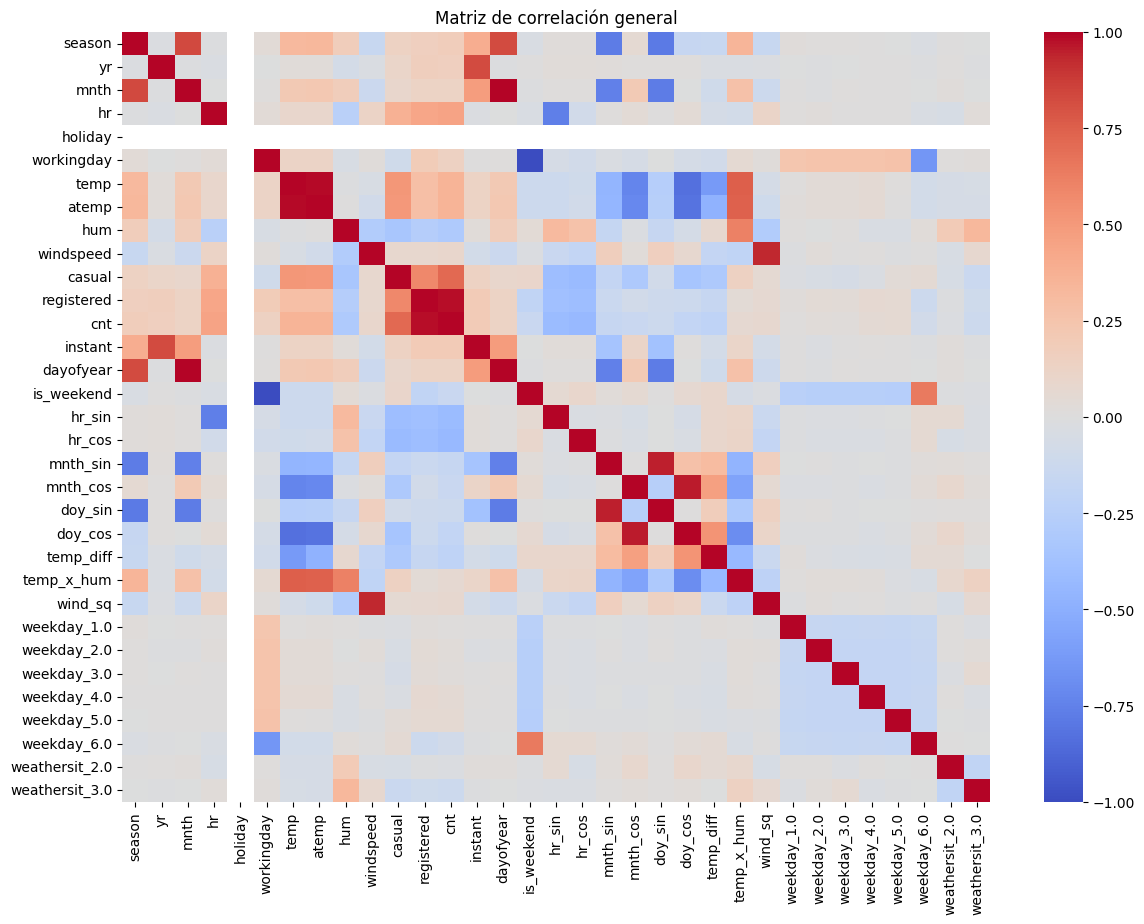

🔹 Correlación con 'cnt':
cnt           1.000000
registered    0.977339
casual        0.716193
hr            0.451256
temp          0.358102
atemp         0.356602
instant       0.200789
season        0.171939
yr            0.164026
workingday    0.142294
mnth          0.129274
dayofyear     0.128199
windspeed     0.093228
wind_sq       0.072824
temp_x_hum    0.067439
Name: cnt, dtype: float64

🔻 Menor correlación con 'cnt':
weathersit_3.0   -0.121626
is_weekend       -0.142294
mnth_cos         -0.143779
mnth_sin         -0.156361
doy_cos          -0.181393
temp_diff        -0.205849
hum              -0.303736
hr_sin           -0.419096
hr_cos           -0.432872
holiday                NaN
Name: cnt, dtype: float64

⚠️ Pares altamente correlacionados (>0.9):


,feature_1,feature_2,corr
71,mnth,dayofyear,0.996615
127,workingday,is_weekend,-1.000000
145,temp,atemp,0.986528
234,windspeed,wind_sq,0.936355
265,registered,cnt,0.977339
392,mnth_sin,doy_sin,0.952754
406,mnth_cos,doy_cos,0.953358


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aseguramos que 'cnt' sea numérica
df_corr = df_model.copy()
df_corr['cnt'] = pd.to_numeric(df_corr['cnt'], errors='coerce')

# Correlaciones solo numéricas
corr = df_corr.corr(numeric_only=True)

# --- 1️⃣ Matriz de correlación general ---
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Matriz de correlación general")
plt.show()

# --- 2️⃣ Correlación con la variable objetivo ---
target_corr = corr['cnt'].sort_values(ascending=False)
print("🔹 Correlación con 'cnt':")
print(target_corr.head(15))
print("\n🔻 Menor correlación con 'cnt':")
print(target_corr.tail(10))

# --- 3️⃣ Identificar pares altamente correlacionados (>0.9) ---
threshold = 0.9
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr'})
)
high_corr_pairs = high_corr_pairs.loc[abs(high_corr_pairs['corr']) > threshold]
print("\n⚠️ Pares altamente correlacionados (>0.9):")
display(high_corr_pairs)


In [13]:
# Eliminar variables redundantes
#to_drop = ['dayofyear', 'atemp', 'wind_sq', 'doy_sin', 'doy_cos']
to_drop=['dayofyear','is_weekend','atemp','wind_sq','doy_sin','doy_cos']
df_selected = df_model.drop(columns=to_drop, errors='ignore')

print("Shape antes:", df_model.shape)
print("Shape después:", df_selected.shape)


Shape antes: (10551, 35)
Shape después: (10551, 29)


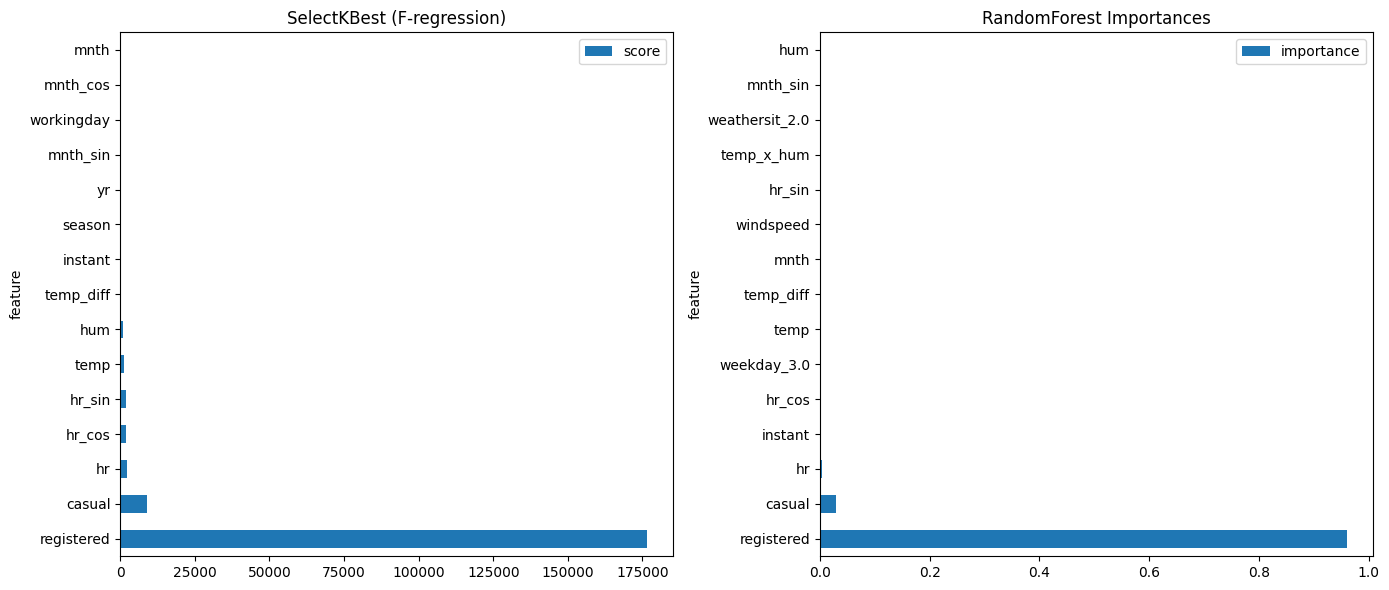

🔹 Top 10 ANOVA:


,feature,score
10,registered,176491.449796
9,casual,8788.226480
3,hr,2181.177262
14,hr_cos,1963.598341
13,hr_sin,1823.180692
6,temp,1228.105558
7,hum,856.023064
17,temp_diff,381.235168
11,instant,340.798320
0,season,242.353187



🔹 Top 10 RF:


,feature,importance
10,registered,0.959892
9,casual,0.028705
3,hr,0.004190
11,instant,0.002236
14,hr_cos,0.001476
21,weekday_3.0,0.000615
6,temp,0.000448
17,temp_diff,0.000328
2,mnth,0.000301
8,windspeed,0.000263


In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- separar X / y
y = df_selected['cnt'].astype(float)
X = df_selected.drop(columns=['cnt'])

# 1) quitar columnas datetime (p. ej., 'dteday')
dt_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
X = X.drop(columns=dt_cols)

# 2) forzar numérico en todo (nullable Int64 -> float)
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# 3) asegurar sin NaN (no debería haber, pero por si acaso)
if X.isna().any().any():
    X = X.fillna(0.0)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- SelectKBest (ANOVA/F-test)
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
anova_scores = pd.DataFrame(
    {'feature': X.columns, 'score': selector.scores_}
).sort_values('score', ascending=False)

# --- Random Forest Importances
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_importances = pd.DataFrame(
    {'feature': X.columns, 'importance': rf.feature_importances_}
).sort_values('importance', ascending=False)

# --- plots rápidos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
anova_scores.head(15).plot.barh(x='feature', y='score', ax=axes[0])
axes[0].set_title('SelectKBest (F-regression)')
rf_importances.head(15).plot.barh(x='feature', y='importance', ax=axes[1])
axes[1].set_title('RandomForest Importances')
plt.tight_layout()
plt.show()

print("🔹 Top 10 ANOVA:")
display(anova_scores.head(10))
print("\n🔹 Top 10 RF:")
display(rf_importances.head(10))


In [ ]:
features_final = [
    'temp', 'hum', 'windspeed',
    'season', 'yr', 'mnth', 'hr',
    'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos',
    'is_weekend', 'holiday', 'workingday',
    'weathersit_2.0', 'weathersit_3.0', 'weathersit_4.0',
    'temp_diff', 'temp_x_hum'
]

features_final=[
    'registered', 'casual', 'hr',
    'hr_cos','hr_sin','temp',
    'hum','temp_diff','instant','season',
    'weekday_3.0','temp_diff','mnth','windspeed'
]


### Model training

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error


# asegurar tipos y quitar columnas no numéricas crudas
df_m = df_selected.copy()
df_m['dteday'] = pd.to_datetime(df_m['dteday'], errors='coerce')
for c in features_final + ['cnt']:
    df_m[c] = pd.to_numeric(df_m[c], errors='coerce')

# Eliminar filas donde 'dteday' es NaT antes de usar .dt
df_m = df_m.dropna(subset=['dteday'])

# 3) split temporal
train = df_m[df_m['dteday'].dt.year == 2011].copy()
valid = df_m[df_m['dteday'].dt.year == 2012].copy()

X_train = train[features_final]
y_train = train['cnt'].astype(float)

X_valid = valid[features_final]
y_valid = valid['cnt'].astype(float)

print("Train:", X_train.shape, "| Valid:", X_valid.shape)


Train: (5491, 14) | Valid: (4948, 14)


In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_valid)

#rmse = mean_squared_error(y_valid, pred_rf, squared=False)
rmse = root_mean_squared_error(y_valid, pred_rf)
mae  = mean_absolute_error(y_valid, pred_rf)
r2   = r2_score(y_valid, pred_rf)

print(f"[RF] VALID → RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")


[RF] VALID → RMSE: 14.123 | MAE: 3.840 | R2: 0.989


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=3.0, random_state=42))
])

pipe_ridge.fit(X_train, y_train)
pred_rg = pipe_ridge.predict(X_valid)

rmse_rg = mean_squared_error(y_valid, pred_rg)
mae_rg  = mean_absolute_error(y_valid, pred_rg)
r2_rg   = r2_score(y_valid, pred_rg)

print(f"[Ridge] VALID → RMSE: {rmse_rg:.3f} | MAE: {mae_rg:.3f} | R2: {r2_rg:.3f}")


[Ridge] VALID → RMSE: 141.919 | MAE: 2.922 | R2: 0.992


In [19]:
results = pd.DataFrame([
    {"model":"RandomForest", "RMSE":rmse, "MAE":mae, "R2":r2},
    {"model":"Ridge",        "RMSE":rmse_rg, "MAE":mae_rg, "R2":r2_rg},
])
results


,model,RMSE,MAE,R2
0,RandomForest,14.123321,3.840409,0.988532
1,Ridge,142.571036,2.147767,0.991803


In [20]:
df_m = df_m.sort_values(by='dteday').copy()
df_m['cnt_lag1'] = df_m['cnt'].shift(1)
df_m['cnt_lag24'] = df_m['cnt'].shift(24)
df_m['cnt_rolling_mean'] = df_m['cnt'].rolling(window=3).mean()

# eliminar primeras filas nulas por lag
df_m = df_m.dropna(subset=['cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean'])
print(df_m[['cnt', 'cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']].head(10))


    cnt  cnt_lag1  cnt_lag24  cnt_rolling_mean
19   20      53.0       16.0         27.000000
17    1      20.0      415.0         24.666667
16    9       1.0       36.0         10.000000
15   17       9.0       37.0          9.000000
14   17      17.0      106.0         14.333333
21   75      17.0       94.0         36.333333
39   72      75.0        8.0         54.666667
44   12      72.0      110.0         53.000000
43   20      12.0        1.0         34.666667
42   52      20.0        1.0         28.000000


In [21]:
corr_lags = df_m[['cnt', 'cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']].corr()
corr_lags

,cnt,cnt_lag1,cnt_lag24,cnt_rolling_mean
cnt,1.000000,0.467750,0.065580,0.741274
cnt_lag1,0.467750,1.000000,0.070679,0.835115
cnt_lag24,0.065580,0.070679,1.000000,0.079635
cnt_rolling_mean,0.741274,0.835115,0.079635,1.000000


In [ ]:
train = df_m[df_m['dteday'].dt.year == 2011].copy()
valid = df_m[df_m['dteday'].dt.year == 2012].copy()

X_train = train[features_final + ['cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']]
y_train = train['cnt'].astype(float)

X_valid = valid[features_final + ['cnt_lag1', 'cnt_lag24', 'cnt_rolling_mean']]
y_valid = valid['cnt'].astype(float)
 


In [23]:
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)

rmse = root_mean_squared_error(y_valid, pred_rf)
mae  = mean_absolute_error(y_valid, pred_rf)
r2   = r2_score(y_valid, pred_rf)

print(f"[RF + Lags] VALID → RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")


[RF + Lags] VALID → RMSE: 11.460 | MAE: 2.843 | R2: 0.992


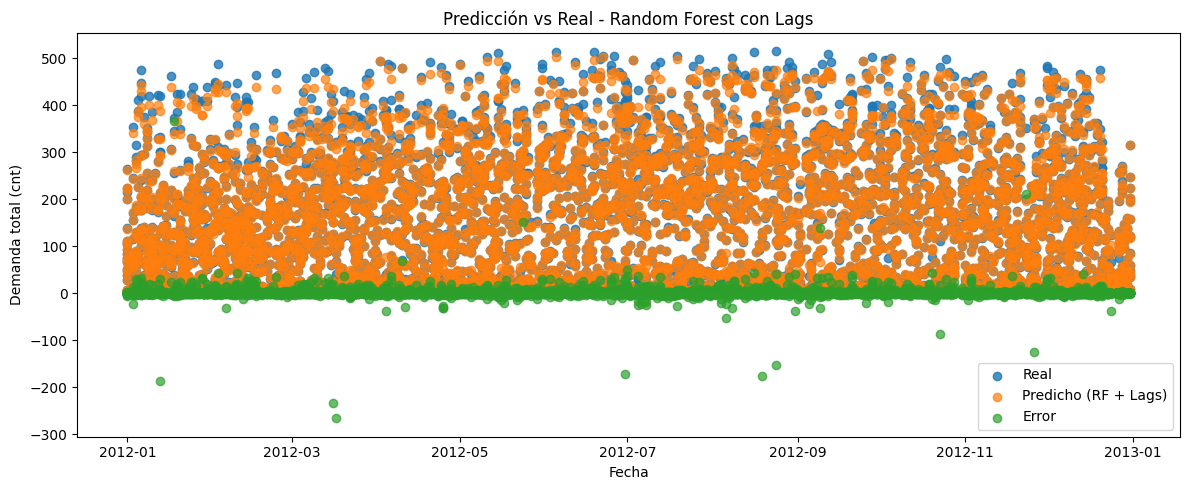

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.scatter(valid['dteday'], y_valid, label='Real', alpha=0.8)
plt.scatter(valid['dteday'], pred_rf, label='Predicho (RF + Lags)', alpha=0.7)
plt.scatter(valid['dteday'], y_valid-pred_rf, label='Error', alpha=0.7)
#plt.errorbar(valid['dteday'], pred_rf, yerr=rmse, fmt='o', color='gray', alpha=0.3, label='Error (RMSE)')
plt.title('Predicción vs Real - Random Forest con Lags')
plt.xlabel('Fecha')
plt.ylabel('Demanda total (cnt)')
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_path = f"../models/random_forest_lags_{timestamp}.pkl"

joblib.dump(rf, model_path)
print(f"Modelo guardado en: {model_path}")


Modelo guardado en: ../models/random_forest_lags_20251116_0351.pkl
